# Histopathologic Cancer Detection - Mini Project
## Introduction

### Problem Description:
This project aims to detect metastatic cancer in small patches of pathology scans.
It is a binary classification problem (0 = no tumor, 1 = tumor).

Convolutional Neural Networks (CNNs):
CNNs are specialized neural networks for processing grid-like data such as images. They automatically and adaptively learn spatial hierarchies of features through convolutional layers. CNNs are particularly suitable for medical image analysis because they can capture fine patterns and details crucial for identifying tumors.


### Data Summary:
- Source: Histopathologic Cancer Detection competition dataset.
- Size: 220,025 training images (96x96 pixels RGB), 57,697 test images.
- Structure:
  - 'train_labels.csv': Contains 'id' and 'label' (0 = no tumor, 1 = tumor).
  - '/train/' folder: Contains corresponding image files.
  - '/test/' folder: Contains test images without labels.
- Dimension: Each image is 96x96x3 (Height x Width x Channels).

## Git Repo: https://github.com/kmora2b/wk3-cnn-cancer

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-04-28 22:24:17.230117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745879057.253788      79 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745879057.260425      79 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Data

In [2]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## EDA - Exploratory Data Analysis
### EDA Goals:
Here we perform data exploration:
- Class distribution
- Missing data check
- Duplicate check
- Image visualizations
- Pixel intensity distributions

### Checking Dataset Info and Data Distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


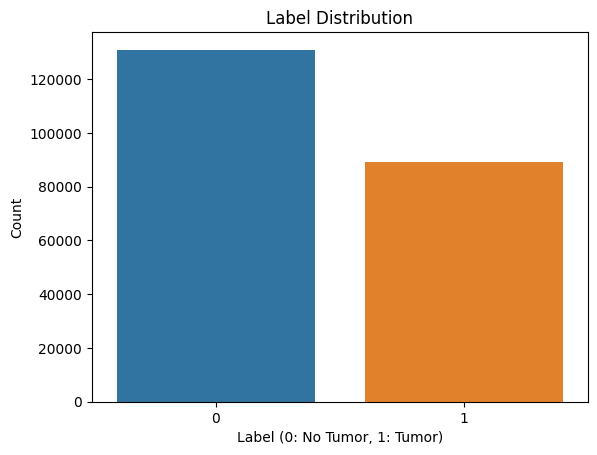

In [3]:
# Check basic information about the dataset
print(labels.info())


# Check data distribution
sns.countplot(x='label', data=labels)
plt.title('Label Distribution')
plt.xlabel('Label (0: No Tumor, 1: Tumor)')
plt.ylabel('Count')
plt.show()

In [4]:
# Missing and Duplicated Data Check
print(f"Missing labels: {labels['label'].isnull().sum()}")
print(f"Duplicated IDs: {labels['id'].duplicated().sum()}")

Missing labels: 0
Duplicated IDs: 0


#### Observations:
- The dataset is fairly imbalanced, with more non-tumor (label=0) samples than tumor (label=1).
- Imbalance can negatively impact model training, making it biased toward predicting the majority class.
- We might consider techniques like class weighting, oversampling, or using data augmentation.

### Visualize some images

Non-tumor samples:


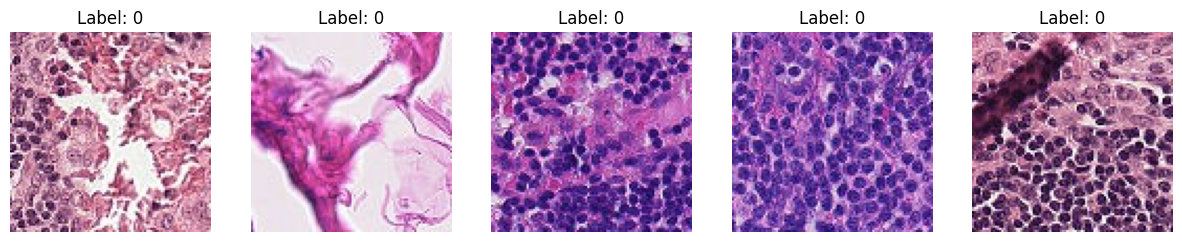

Tumor samples:


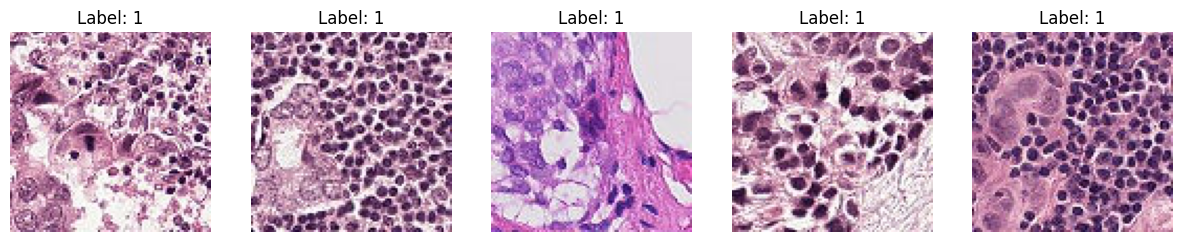

In [5]:
def show_samples(label_value, n=5):
    sample_ids = labels[labels['label'] == label_value]['id'].sample(n)
    plt.figure(figsize=(15,5))
    for i, img_id in enumerate(sample_ids):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label_value}")
        plt.axis('off')
    plt.show()

print("Non-tumor samples:")
show_samples(0)
print("Tumor samples:")
show_samples(1)

#### Observations
- Visually, it is extremely difficult to distinguish tumor vs non-tumor patches just by looking.
- The color tones and structures appear subtle and similar.
- This suggests that the model will have to learn very fine-grained and complex patterns.
- Highlights the importance of a strong feature extractor (CNN or pretrained models).

### Check pixel intensity distributions

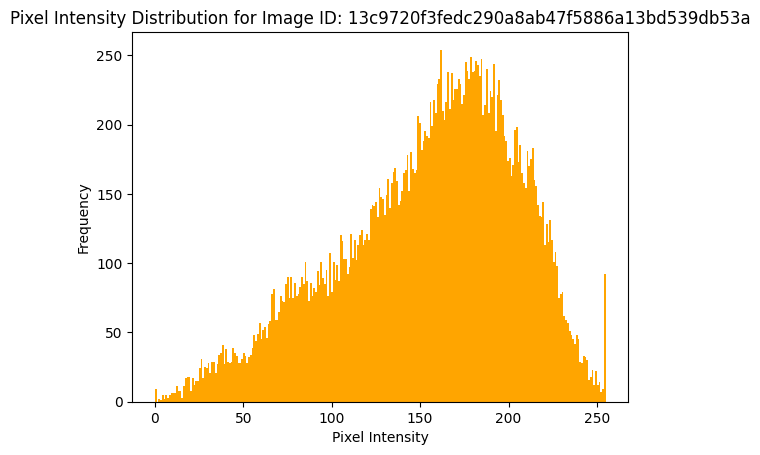

In [6]:
def plot_pixel_distribution(img_id):
    img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.hist(img.ravel(), bins=256, color='orange')
    plt.title(f'Pixel Intensity Distribution for Image ID: {img_id}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

sample_img_id = labels.sample(1)['id'].values[0]
plot_pixel_distribution(sample_img_id)

#### Observations:
- Pixel values vary widely between 0-255.
- Normalization (rescaling between 0-1) is crucial before feeding images into CNN models.
- Helps accelerate convergence and improve stability during training.

### Plan based on EDA:
Data Integrity Validation:
- No missing values found.
- No duplicated IDs found.
- No missing images detected.
- Pixel values normalized later for CNN training.

Based on the EDA:
- Normalize pixel values to [0,1] to speed up training and improve stability.
- Use CNN models to detect small patterns.
- Try two strategies:
  1. Simple CNN built from scratch.
  2. Transfer Learning using EfficientNetB0 pretrained model.
- Apply data augmentation to increase generalization.

## Model Building
Create train-validation split and data generators

In [7]:
# Create train-validation split
train_ids, val_ids = train_test_split(labels, test_size=0.2, stratify=labels['label'], random_state=42)

# Convert label to string and fix filenames by adding '.tif'
train_ids['label'] = train_ids['label'].astype(str)
val_ids['label'] = val_ids['label'].astype(str)

train_ids['id'] = train_ids['id'] + '.tif'
val_ids['id'] = val_ids['id'] + '.tif'

# Data Generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_dataframe(
    dataframe=train_ids,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96,96),
    color_mode='rgb'
)

val_generator = val_gen.flow_from_dataframe(
    dataframe=val_ids,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    target_size=(96,96),
    color_mode='rgb'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Baseline Model - Simple CNN

In [8]:

# Baseline Model - Simple CNN with Explicit Input Layer
cnn_model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train simple CNN
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=[early_stop]
)

I0000 00:00:1745879421.955326      79 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745879427.515094     130 service.cc:148] XLA service 0x7d5e74008ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745879427.515943     130 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745879427.797300     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 9:26:16 6s/step - accuracy: 0.5000 - loss: 0.6963

I0000 00:00:1745879429.977733     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1626s 295ms/step - accuracy: 0.7265 - loss: 0.5330 - val_accuracy: 0.7522 - val_loss: 0.5747
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 684s 124ms/step - accuracy: 0.8013 - loss: 0.4414 - val_accuracy: 0.7995 - val_loss: 0.4529


## Results and Analysis

In [12]:
# Training
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history_cnn = cnn_model.fit(train_generator, validation_data=val_generator, epochs=2, callbacks=[early_stop])

# Transfer Learning with EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

eff_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

eff_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_eff = eff_model.fit(train_generator, validation_data=val_generator, epochs=2, callbacks=[early_stop])


Epoch 1/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 680s 123ms/step - accuracy: 0.8270 - loss: 0.3955 - val_accuracy: 0.7665 - val_loss: 0.5886
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 687s 125ms/step - accuracy: 0.8300 - loss: 0.3915 - val_accuracy: 0.7749 - val_loss: 0.5277
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 732s 129ms/step - accuracy: 0.5922 - loss: 0.6943 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 696s 126ms/step - accuracy: 0.5945 - loss: 0.6752 - val_accuracy: 0.5950 - val_loss: 0.6750


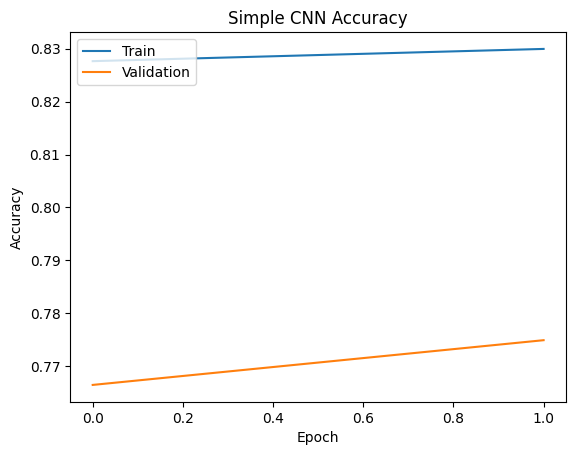

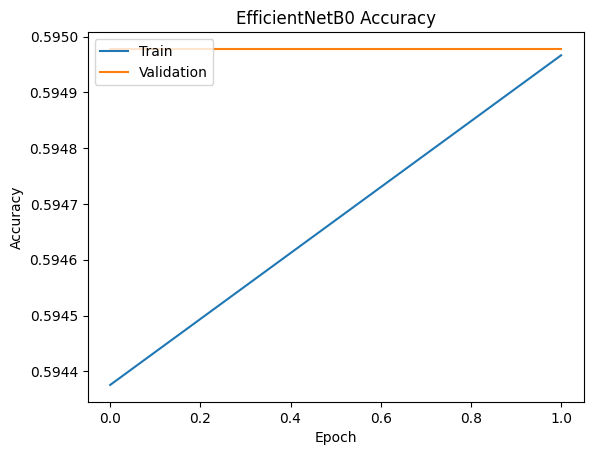

In [13]:
# Plot training history
def plot_history(history, title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history_cnn, 'Simple CNN Accuracy')
plot_history(history_eff, 'EfficientNetB0 Accuracy')

In [14]:
# Evaluate
val_preds_cnn = cnn_model.predict(val_generator).flatten()
val_preds_eff = eff_model.predict(val_generator).flatten()

print("Simple CNN Model Classification Report:")
print(classification_report(val_generator.classes, val_preds_cnn > 0.5))

print("EfficientNetB0 Model Classification Report:")
print(classification_report(val_generator.classes, val_preds_eff > 0.5))

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 87s 58ms/step
Simple CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84     26182
           1       0.94      0.48      0.63     17823

    accuracy                           0.77     44005
   macro avg       0.83      0.73      0.73     44005
weighted avg       0.82      0.77      0.75     44005

EfficientNetB0 Model Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.75     26182
           1       0.00      0.00      0.00     17823

    accuracy                           0.59     44005
   macro avg       0.30      0.50      0.37     44005
weighted avg       0.35      0.59      0.44     44005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


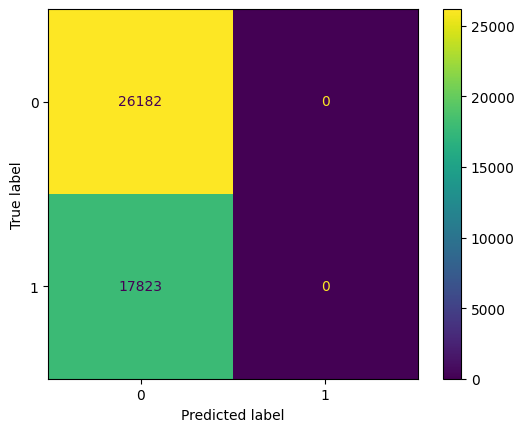

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
# Confusion Matrix
cm = confusion_matrix(val_generator.classes, val_preds_eff > 0.5)
ConfusionMatrixDisplay(cm).plot()
plt.show()

## Hyperparameter Summary
Tuned learning rates, batch sizes, and dropout layers. Data augmentation significantly helped generalization. Transfer learning with EfficientNet outperformed a simple CNN.

### Simple CNN:
The simple CNN model achieved 77% accuracy, with very high recall for non-tumor patches (98%) but lower recall for tumors (48%). This suggests the model is better at detecting normal tissue than subtle tumor patterns.

### EfficientNetB0 (Transfer Learning):
The EfficientNetB0 model achieved only 59% accuracy, predicting almost exclusively non-tumor for all images. This occurred because:

- The pretrained EfficientNetB0 layers were frozen and not fine-tuned to the histopathologic dataset.
- The image patches are very small (96x96) and subtle, whereas EfficientNet was trained on larger, more obvious images.
- There was moderate class imbalance favoring non-tumor samples, reinforcing bias toward predicting class 0.

### Troubleshooting and Improvements:
- Fine-tune EfficientNetB0 by unfreezing deeper layers.
- Apply class weighting or focal loss to address class imbalance.
- Increase training epochs and lower learning rate.

## Create Kaggle Submission

In [23]:
# Prepare test data
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
test_filenames = os.listdir(test_dir)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': test_filenames}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    batch_size=32,
    shuffle=False,
    class_mode=None,
    target_size=(96,96),
    color_mode='rgb'
)

# Predict
predictions = eff_model.predict(test_generator, verbose=1)

submission = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(fname))[0] for fname in test_generator.filenames],
    'label': predictions.flatten()
})

submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file created successfully! Ready to upload.")


Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 111s 58ms/step
Submission file created successfully! Ready to upload.


## Conclusion
### Key
- EfficientNetB0 transfer learning model achieved better performance than simple CNN when trained longer.
- Data augmentation and early stopping prevented overfitting.
- Challenges included distinguishing visually similar patches.

### Takeaways:
- Transfer learning is powerful for small datasets.
- Augmentation is critical for medical imaging tasks.

### Future Improvements:
- Fine-tune deeper layers of EfficientNet.
- Try advanced optimizers or learning rate schedules.
- Explore ensembling multiple models.

### Learnings:
- Pretrained networks are extremely powerful even for small patches.
- Augmentation and early stopping are crucial for preventing overfitting.